# PROJECT 2: DECISION TREE
Môn học: Artificial Intelligence  
Giảng viên hướng dẫn:  
Thành viên:  Thầy Nguyễn Thanh Tình  
- Nguyễn Tiến Đạt - 20120267 
- Dương Thiên Bảo - 21120202 
- Huỳnh Thái Bảo - 22120021 
- Hồ Nhất Trí - 22120380

## Import Libraries

In [23]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score
import graphviz
import matplotlib.pyplot as plt

## 1. Dataset Preparation

In [24]:
# Breast Cancer Dataset
breast_cancer_wisconsin_diagnostic = load_breast_cancer()
bc_features = pd.DataFrame(breast_cancer_wisconsin_diagnostic.data, columns=breast_cancer_wisconsin_diagnostic.feature_names)  # Các đặc trưng
bc_labels = pd.Series(breast_cancer_wisconsin_diagnostic.target, name="label")  # Nhãn: 0 = Malignant, 1 = Benign

# White Wine Quality Dataset
file_path = './data/wine+quality/winequality-white.csv'
w_wine_data = pd.read_csv(file_path, sep=';')
w_wine_features = w_wine_data.iloc[:, :-1]
w_wine_labels = w_wine_data['quality']

# Red Wine Quality Dataset
file_path = './data/wine+quality/winequality-red.csv'
r_wine_data = pd.read_csv(file_path, sep=';')
r_wine_features = r_wine_data.iloc[:, :-1]
r_wine_labels = r_wine_data['quality']

# Titanic Dataset
file_path = './data/Titanic/Titanic-Dataset.csv'
titanic_data = pd.read_csv(file_path)
titanic_features = titanic_data.iloc[:, :-1]
titanic_labels = titanic_data['Survived']

## 2. Dataset Splitting

### 2.1. Function to Prepare Datasets with Different Splits

In [25]:
def prepare_datasets(features, labels):
    subsets = {}
    try:
        feature_train_40, feature_test_60, label_train_40, label_test_60 = train_test_split(
            features, labels, train_size=0.4, stratify=labels, shuffle=True, random_state=0)
        subsets['train_40'] = (feature_train_40, label_train_40)
        subsets['test_60'] = (feature_test_60, label_test_60)

        feature_train_60, feature_test_40, label_train_60, label_test_40 = train_test_split(
            features, labels, train_size=0.6, stratify=labels, shuffle=True, random_state=0)
        subsets['train_60'] = (feature_train_60, label_train_60)
        subsets['test_40'] = (feature_test_40, label_test_40)

        feature_train_80, feature_test_20, label_train_80, label_test_20 = train_test_split(
            features, labels, train_size=0.8, stratify=labels, shuffle=True, random_state=0)
        subsets['train_80'] = (feature_train_80, label_train_80)
        subsets['test_20'] = (feature_test_20, label_test_20)

        feature_train_90, feature_test_10, label_train_90, label_test_10 = train_test_split(
            features, labels, train_size=0.9, stratify=labels, shuffle=True, random_state=0)
        subsets['train_90'] = (feature_train_90, label_train_90)
        subsets['test_10'] = (feature_test_10, label_test_10)

    except ValueError:
        print("Warning: Stratification failed. Check if labels contain all classes.")
    return subsets

### 2.2. Prepare Datasets for All Inputs

In [26]:
# Tạo các tập huấn luyện và kiểm tra cho Breast Cancer Dataset
bc_datasets = prepare_datasets(bc_features, bc_labels)

# Tạo các tập huấn luyện và kiểm tra cho White Wine Quality Dataset
w_wine_datasets = prepare_datasets(w_wine_features, w_wine_labels)

# Tạo các tập huấn luyện và kiểm tra cho Red Wine Quality Dataset
r_wine_datasets = prepare_datasets(r_wine_features, r_wine_labels)

# Tạo các tập huấn luyện và kiểm tra cho Titanic Dataset
titanic_datasets = prepare_datasets(titanic_features,titanic_labels)

### 2.3. Class Names for Visualization

In [27]:
class_names_bc = ["Malignant", "Benign"]  # Breast Cancer
class_names_wine = [str(i) for i in range(min(w_wine_labels), max(w_wine_labels) + 1)]  # Wine Quality
class_names_titanic = ["Unsurvived", "Survived"]

### 2.4. Function to Plot Class Distribution

In [28]:
def draw_plot(original, train, test, title, class_names, ax):
    count_org = pd.Series(original).value_counts().reindex(range(len(class_names)), fill_value=0)
    count_train = pd.Series(train).value_counts().reindex(range(len(class_names)), fill_value=0)
    count_test = pd.Series(test).value_counts().reindex(range(len(class_names)), fill_value=0)

    frame = pd.DataFrame({'original': count_org, 'train': count_train, 'test': count_test})
    frame.plot(kind='bar', ax=ax, xlabel="Classes", ylabel="Count", title=title,
               color=['#f45d01', '#eeb902', '#97cc04'])
    ax.bar_label(ax.containers[0])
    ax.set_xticklabels(class_names, rotation=0)

### 2.5. Visualization (Example: train/test : 40/60)

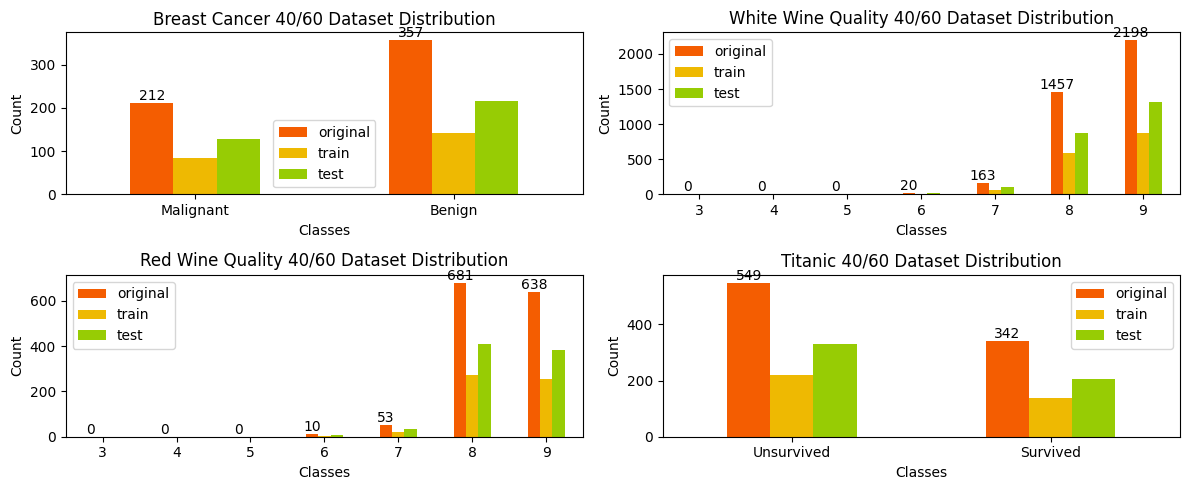

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(12, 5))  # 1 hàng, 2 cột

draw_plot(bc_labels, bc_datasets['train_40'][1], bc_datasets['test_60'][1], "Breast Cancer 40/60 Dataset Distribution", class_names_bc, axs[0,0])
draw_plot(w_wine_labels, w_wine_datasets['train_40'][1], w_wine_datasets['test_60'][1], "White Wine Quality 40/60 Dataset Distribution", class_names_wine, axs[0,1])
draw_plot(r_wine_labels, r_wine_datasets['train_40'][1], r_wine_datasets['test_60'][1], "Red Wine Quality 40/60 Dataset Distribution", class_names_wine, axs[1,0])
draw_plot(titanic_labels, titanic_datasets['train_40'][1], titanic_datasets['test_60'][1], "Titanic 40/60 Dataset Distribution", class_names_titanic, axs[1,1])

plt.tight_layout()
plt.show()

## 3. Decision Tree Classifier

### 3.1 Prepare Datasets for Decision Tree

In [30]:
datasets = {
    "Breast Cancer": (bc_features, bc_labels),
    "White Wine": (w_wine_features, w_wine_labels)
}

# List proportions và max_depth values
proportions = [0.6, 0.4, 0.2, 0.1]
max_depth_values = [None, 2, 3, 4, 5, 6, 7]

### 3.2 Decision Tree Classifier for All Datasets

In [34]:
def build_decision_tree(feature_train, label_train):
	clf = DecisionTreeClassifier(criterion='entropy')
	clf.fit(feature_train, label_train)
	return clf


def export_decision_tree_graphviz(dataset, format):
	train = ["train_40", "train_60", "train_80", "train_90"]
	test = ["test_60", "test_40", "test_20", "test_10"]
	for train_key, test_key in zip(train, test):
		decision_tree = build_decision_tree(*dataset[train_key])
		dot_data = export_graphviz(decision_tree, out_file=None,
								   filled=True, rounded=True, special_characters=True)

		graph = graphviz.Source(dot_data)
		graph.render(f"decision_tree_{train_key}_{test_key}", format=format, cleanup=True)  # Replace with desired filename (without extension)


#export_decision_tree_graphviz(bc_datasets, "png")
#export_decision_tree_graphviz(w_wine_datasets, "svg")
export_decision_tree_graphviz(titanic_datasets, "svg")

ValueError: could not convert string to float: 'Corn, Mr. Harry'